<a href="https://colab.research.google.com/github/amfakh/LSTM-Movie-Review/blob/master/2b.%20Using%20Bidirectional%20LSTM" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Force Tensorflow version 1.13.1

In [ ]:
!pip install tensorflow==1.13.1
!pip install -qq -U cufflinks
!pip install matplotlib==3.1.0
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

## Access Google Drive files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%cd /content/drive/My\ Drive/

/content/drive/My Drive


# Read all the Files

## Read the dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("df.csv")

In [ ]:
df.head()

,Unnamed: 0,rating,title,review,number,cleaned,sentiment
0,0,10/10,Unlike anything ever done in the history of ci...,This movie is the beginning of the culmination...,10.0,beginning culmination masterfully woven cinema...,1
1,1,10/10,This movie will blow your mind and break your ...,"Over the past decade, Marvel has earned itself...",10.0,past decade earned benefit doubt consistently ...,1
2,2,10/10,Way better than endgame,This film is way better than endgame!\nThe act...,10.0,way better action better writing better dialog...,1
3,3,10/10,A Summer Film That IS Even Better Than The Hype,Summer movies often hype themselves as spectac...,10.0,summer often hype spectacular event missed ad ...,1
4,4,9/10,Excellent Film,I was amazed to see so many negative reviews; ...,9.0,amazed negative impossible please hour long co...,1


# Data

## Split dataset into datatrain and datatest

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# for sent in df:
train_review = df['cleaned'].values
y_train = df['sentiment'].values

    # train_review, test_review, y_train, y_test = train_test_split(
    #     review, y, test_size=0.3, shuffle=True)

## Convert text to Bag of Words

In [ ]:
from keras.preprocessing.text import Tokenizer

# Make sure the data type is str
review_train = train_review.astype(str)
# review_test = test_review.astype(str)

tokenizer = Tokenizer(char_level=False)
tokenizer.fit_on_texts(review_train)
text_train = tokenizer.texts_to_sequences(review_train)
# text_test = tokenizer.texts_to_sequences(review_test)

Using TensorFlow backend.


### (Additional) Declare the vocab size to maximum

In [ ]:
max_words = len(tokenizer.word_index) + 1  
# Adding 1 because of reserved 0 index
print('%s unique words.' % max_words)

37657 unique words.


### (Additional) Declare maximum length to maximum

In [ ]:
text_len = [len(r) for r in text_train]
print("average length: %0.1f" % np.mean(text_len))
print("max length: %d" % max(text_len))

average length: 75.4
max length: 899


In [ ]:
# plt.hist(text_len, bins=500);

## Declare max_words and max_len

In [ ]:
# Number of words to consider as features
# max_words = 50000
# Cut texts after this number of words (among top max_features most common words)
max_len = 500

## Pad Sequences

In [ ]:
# tokenizer.word_index

In [ ]:
from keras.preprocessing.sequence import pad_sequences

# max_length = max(text_len)

# pad sequences with 0s
x = pad_sequences(text_train, maxlen=max_len)
# x_test = pad_sequences(text_test, maxlen=max_len)
print('Shape of data tensor:', x.shape)
# print('Shape of data test tensor:', x_test.shape)

Shape of data tensor: (25136, 500)


### Check the data

In [ ]:
# print(review_train[4])
# print(x_train[4])

In [ ]:
# print(y_train[0])
# print(y_test[0])

Convert label to float

In [ ]:
y = np.asarray(y_train).astype('float32').reshape((-1,1))
# y_test = np.asarray(y_test).astype('float32').reshape((-1,1))

In [ ]:
print(y_train)

[1 1 1 ... 1 0 0]


In [ ]:
# from keras import utils
# num_classes = 2

# y_train_binary = utils.to_categorical(y_train, num_classes)
# y_test_binary = utils.to_categorical(y_test, num_classes)

In [ ]:
# print(y_train_binary)

# Model

## Import stuff

In [ ]:
from tensorflow.python.keras.layers import Dropout, Dense, Embedding
from tensorflow.python.keras.layers import SpatialDropout1D, GlobalMaxPool1D
from tensorflow.python.keras.layers import LSTM, Input, Bidirectional, GRU

print(tf.__version__)
print(tf.keras.__version__)

1.13.1
2.2.4-tf


In [ ]:
input_dim = x.shape[1]  # Number of features
embedding_dim = 128
learning_rate = 2e-5
epochs = 500
decay_rate = 1e-3 # learning_rate / epochs

def make_model(batch_size=None):
  source = Input(shape=(max_len,), name='Input')
  embedding = Embedding(input_dim=max_words,
                        output_dim=embedding_dim,
                        input_length=max_len)(source)
  # spatial = SpatialDropout1D(0.4)(embedding)
  lstm = Bidirectional(LSTM(128, 
              # activation='softsign',
              dropout=0.3,
              recurrent_dropout=0.3,
              # use_bias=True
              # ,return_sequences=True
              ))(embedding)
  # pool = GlobalMaxPool1D()(lstm)
  # dense = Dense(24)(lstm)
  # drop = Dropout(0.4)(dense)

  # lstm = Bidirectional(LSTM(196, activation='softsign',
  #           dropout=0.7,
  #           recurrent_dropout=0.7,
  #           use_bias=True
  #           # ,return_sequences=True
  #           ))(drop)
  # dense = Dense(50)(lstm)
  # drop = Dropout(0.7)(dense)

  predict = Dense(1, activation='sigmoid')(lstm)

  model = tf.keras.Model(inputs=[source], outputs=[predict])

  rmsprop = tf.train.RMSPropOptimizer(learning_rate=learning_rate, decay=decay_rate)
  model.compile(
      optimizer=rmsprop,
      loss='binary_crossentropy',
      metrics=['accuracy']
  )
  return model

In [ ]:
import os

TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
tf.logging.set_verbosity(tf.logging.INFO)

# tpu_model.summary()

In [ ]:
seed = 42
np.random.seed(seed)

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Train acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Train and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Train loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Train and validation loss')
    plt.legend()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve,roc_auc_score

import seaborn as sns



# sns.set()
# sns.heatmap(confusion.T, square=True, annot=True, fmt='d', cbar=False,
#             xticklabels=np.unique(y_pred),
#             yticklabels=np.unique(y_pred))
# plt.xlabel('true label')
# plt.ylabel('predicted label')
# plt.title('Confusion Matrix Prediction')

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
import time, math
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)

tr_acc_array = []
tr_loss_array = []
te_acc_array = []
te_loss_array = []
time_array = []
rmse_array = []

n=0


for train, test in kfold.split(x, y):
  n+=1
  print("--- Fold %d ---" % (n))
  tf.keras.backend.clear_session()
  training_model = make_model(batch_size = 128)
  # training_model.summary()

  tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    training_model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))

  start_time = time.time()
  history = tpu_model.fit(x[train], y[train]
                    ,epochs=epochs, verbose=1 
                    ,validation_split=0.2
                    ,batch_size=128 * 8
                    ,validation_data=(x[test], y[test])
                    ,callbacks=[es]
                   )
  print("--- %s seconds ---" % (time.time() - start_time))
  time_array.append(time.time() - start_time)

  model = tpu_model.sync_to_cpu()

  tr_loss, tr_accuracy = model.evaluate(x[train], y[train], verbose=1)
  te_loss, te_accuracy = model.evaluate(x[test], y[test], verbose=1)
  print("Train Accuracy: {:.4f}".format(tr_accuracy))
  tr_acc_array.append(tr_accuracy)
  print("Train Loss: {:.4f}".format(tr_loss))
  tr_loss_array.append(tr_loss)
  print("Validation Accuracy:  {:.4f}".format(te_accuracy))
  te_acc_array.append(te_accuracy)
  print("Validation Loss: {:.4f}".format(te_loss))
  te_loss_array.append(te_loss)

  pred = model.predict(x[test], batch_size=1000, verbose = 1)
  y_pred = y_pred = (pred > 0.5)

  print(confusion_matrix(y[test], y_pred))
  # sns.set()
  # sns.heatmap(confusion.T, square=True, annot=True, fmt='d', cbar=False,
  #             xticklabels=np.unique(y_pred),
  #             yticklabels=np.unique(y_pred))
  # plt.xlabel('true label')
  # plt.ylabel('predicted label')
  # plt.title('Confusion Matrix Prediction')


  print(classification_report(y[test], y_pred))

  # calculate root mean squared error
  rmse = math.sqrt(mean_squared_error(y[test], y_pred))
  print('RMSE: %.4f' % (rmse))
  rmse_array.append(rmse)
  # testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
  # print('Test Score: %.2f RMSE' % (testScore))

  # auc_score=roc_auc_score(y[test], y_pred)  
  # print('AUC: %.2f' % (auc_score))

  # cvscores.append(scores[1] * 100)

  # plot_history(history)



--- Fold 1 ---
INFO:tensorflow:Querying Tensorflow master (grpc://10.76.36.210:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 1277633526131077744)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 6387720827749024011)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 10496896205887535107)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 6969718561809677301)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 12961930590832392281)
INFO:tensorflow:*** Available Device: _De

In [ ]:
print("Average Train Accuracy: %.4f%% (+/- %.4f%%)" % (np.mean(tr_acc_array), np.std(tr_acc_array)))
print("Average Train Loss: %.4f%% (+/- %.4f%%)" % (np.mean(tr_loss_array), np.std(tr_loss_array)))
print("Average Validation Accuracy: %.4f%% (+/- %.4f%%)" % (np.mean(te_acc_array), np.std(te_acc_array)))
print("Average Validation Loss: %.4f%% (+/- %.4f%%)" % (np.mean(te_loss_array), np.std(te_loss_array)))
print("Average Time: %.4f%% (+/- %.4f%%)" % (np.mean(time_array), np.std(time_array)))
print("Average RMSE: %.4f%% (+/- %.4f%%)" % (np.mean(rmse_array), np.std(rmse_array)))

Average Train Accuracy: 0.8940% (+/- 0.0030%)
Average Train Loss: 0.2661% (+/- 0.0077%)
Average Validation Accuracy: 0.8532% (+/- 0.0042%)
Average Validation Loss: 0.3420% (+/- 0.0070%)
Average Time: 1164.1215% (+/- 86.6439%)
Average RMSE: 0.3831% (+/- 0.0054%)


In [ ]:
dataset = pd.DataFrame({'Train Acc': tr_acc_array, 'Train Loss': tr_loss_array, 'Validation Acc': te_acc_array, 'Validation Loss': te_loss_array, 'Time': time_array, 'RMSE': rmse_array})
# dataset.to_csv('data_blstm.csv')

In [ ]:
dataset

,Train Acc,Train Loss,Validation Acc,Validation Loss,Time,RMSE
0,0.888801,0.280142,0.851432,0.341470,1024.128362,0.385445
1,0.894376,0.264465,0.851005,0.342011,1148.033411,0.385999
2,0.897061,0.257576,0.847822,0.353929,1136.338805,0.390100
3,0.896514,0.261225,0.856177,0.340726,1257.482391,0.379240
4,0.893033,0.266852,0.859558,0.331989,1254.624696,0.374755


In [ ]:
# import time
# from keras.callbacks import ReduceLROnPlateau, EarlyStopping
# start_time = time.time()

# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)

  
# history = tpu_model.fit(x_train, y_train
#                     ,epochs=epochs, verbose=1 
#                     ,validation_split=0.2
#                     ,batch_size=128 * 8
#                     ,validation_data=(x_test, y_test)
#                     ,callbacks=[es]
#                    )
# print("--- %s seconds ---" % (time.time() - start_time))
# # tpu_model.save_weights('./tpu_model.h5', overwrite=True)

In [ ]:
# loss, accuracy = tpu_model.evaluate(x_train, y_train, verbose=1)
# print("Training Accuracy: {:.4f}".format(accuracy))
# loss, accuracy = tpu_model.evaluate(x_test, y_test, verbose=1)
# print("Testing Accuracy:  {:.4f}".format(accuracy))

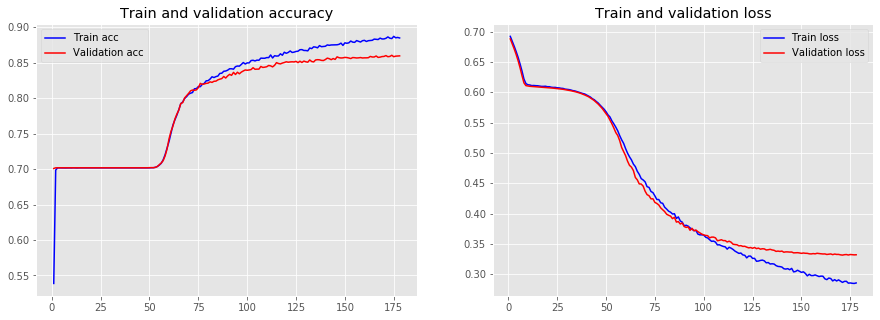

In [ ]:
plot_history(history)

In [ ]:
check_df = pd.DataFrame(list(zip(df['review'].values, df['cleaned'].values, df['sentiment'].values, y_pred)), columns = ['review','cleaned','sentiment','predict'])
# df['predict'] = df['predict'].astype(int)1

In [ ]:
check_df

,review,cleaned,sentiment,predict
0,This movie is the beginning of the culmination...,beginning culmination masterfully woven cinema...,1,[True]
1,"Over the past decade, Marvel has earned itself...",past decade earned benefit doubt consistently ...,1,[True]
2,This film is way better than endgame!\nThe act...,way better action better writing better dialog...,1,[True]
3,Summer movies often hype themselves as spectac...,summer often hype spectacular event missed ad ...,1,[True]
4,I was amazed to see so many negative reviews; ...,amazed negative impossible please hour long co...,1,[True]
...,...,...,...,...
5022,"Admittingly, I was not a fan of the original. ...",admittingly fan original found first eye candi...,0,[False]
5023,"Like the first round, it appears it is always ...",like first round appears always smart keep ori...,1,[True]
5024,With the exception of 'Captain America: The Wi...,exception america winter soldier cinematic uni...,1,[False]
5025,I loved it! It was funny and witty and had all...,loved funny witty ingredient make best film fa...,1,[True]


# Predict

In [ ]:
nan = pd.read_csv("nan.csv")

In [ ]:
nan.head()

,Unnamed: 0,rating,title,review,number,cleaned
0,69,NaN,A tedious and dependent film,SPOILER: The plot is simple that the supervill...,0,spoiler simple supervillian succeeds russo bro...
1,126,NaN,Thanos the Emo Crybaby...Thanos Mickey Mouse S...,12 jokes within 3 minutes in conversation betw...,0,joke within minute conversation doctor strange...
2,139,NaN,A snore -- literally,This film was complete and utter tosh. Judging...,0,complete utter tosh judging way positively rev...
3,146,NaN,"Thanos and Bubbles, Kiddie Mickey Mouse Style",I don't recognize the THANOS The MAD TITAN fro...,0,recognize thanos mad titan comic book thanos w...
4,176,NaN,"Good movie, but completely ruined",Spoilers!!!Spoilers: the movie was pretty good...,0,spoiler spoiler pretty good bit quippy good en...


In [ ]:
nan.shape

(533, 6)

In [ ]:
for sent in nan:
    review = nan['review'].values
    cleaned = nan['cleaned'].values

In [ ]:
cleaned_str = cleaned.astype(str)

tokenizer = Tokenizer(char_level=False)
tokenizer.fit_on_texts(cleaned_str)
cleaned_bow = tokenizer.texts_to_sequences(cleaned_str) #text_train

In [ ]:
x_pred = pad_sequences(cleaned_bow, maxlen=max_len)
print('Shape of data tensor:', x_pred.shape)

Shape of data tensor: (533, 500)


In [ ]:
pred = model.predict(x_pred, batch_size=100, verbose = 1)
y_pred = (pred > 0.5)

533/533 [==============================] - 1s 2ms/sample


In [ ]:
pred_df = pd.DataFrame(list(zip(review, y_pred)), columns = ['review','predict'])


In [ ]:
pred_df

,review,predict
0,SPOILER: The plot is simple that the supervill...,[True]
1,12 jokes within 3 minutes in conversation betw...,[True]
2,This film was complete and utter tosh. Judging...,[False]
3,I don't recognize the THANOS The MAD TITAN fro...,[True]
4,Spoilers!!!Spoilers: the movie was pretty good...,[True]
...,...,...
528,Just finished watching this movie. My husband ...,[True]
529,Ok at best. Big script let down from what's su...,[True]
530,"Had this movie come out in 2009 close to ""Iron...",[True]
531,I'm a middle-aged white male. Saw Captain Marv...,[False]


In [ ]:
pred_df.to_csv('pred_blstm.csv')

In [ ]:
model.save("blstm.h5")